In [23]:
import numpy as np
import pathlib
import os, sys
from IPython.display import Image
import tensorflow as tf
#from PIL import Image
#import numpy as np
#☻import cv2
from tensorflow.keras.models import load_model

In [24]:
def get_f_names():
    lst=[]
    for x in os.listdir():
        if x.endswith("jpg"):
            lst.append(x)
    return lst

In [25]:
def get_random_jpg_file():
    return numpy.random.choice(get_f_names())

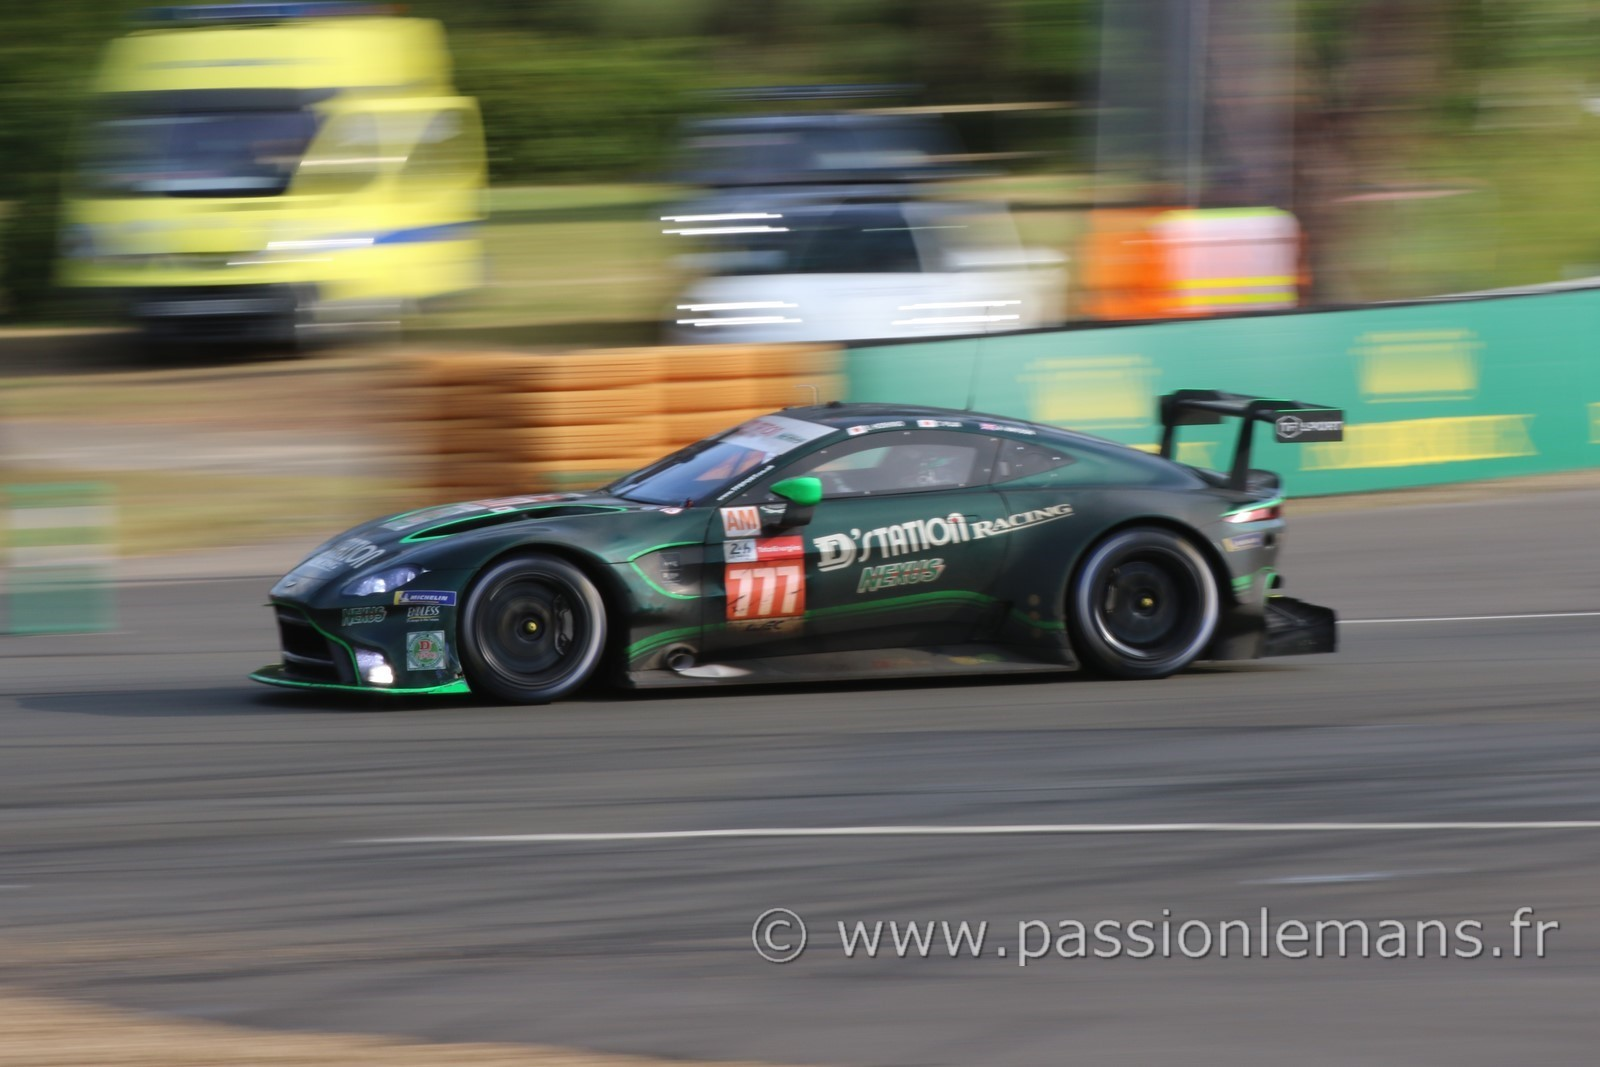

In [26]:
img_base_path=get_random_jpg_file()
pil_img = Image(filename=img_base_path)
pil_img

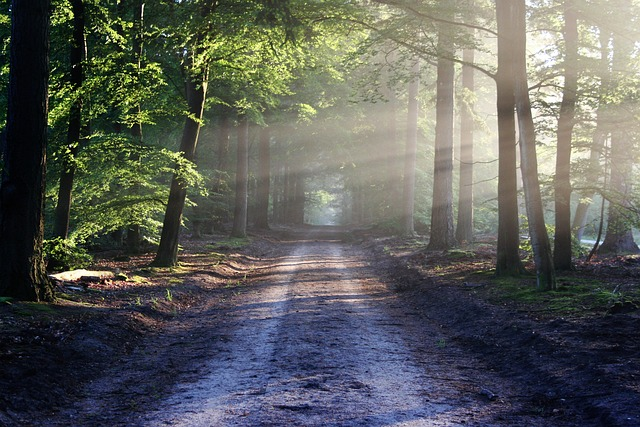

In [27]:
pic_style_img=Image(filename='styles_pic/pic_style_road_forest.jpg')
pic_style_img




***Model et Prétaitements des images***

In [29]:
# Charger le modèle pré-entrainé
model = load_model('unet_model.h5')

# Charger les images
img_base = cv2.imread(img_base_path.jpg)
img_style = cv2.imread('styles_pic/pic_style_road_forest.jpg')

# Redimensionner l'image 2 pour qu'elle soit de la même taille que l'image 1
img_style = cv2.resize(img_style, (img_base.shape[1], img_base.shape[0]))

# Prétraitement de l'image 1
img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
img_base = img_base / 255.0

# Prétraitement de l'image 2
img_style = cv2.cvtColor(img_style, cv2.COLOR_BGR2RGB)
img_style = img_style / 255.0

OSError: SavedModel file does not exist at: unet_model.h5/{saved_model.pbtxt|saved_model.pb}

***Appliquer un masque à l'image qui servira au Custom***

In [ ]:
# Prédire la segmentation de l'image 1 en utilisant l'image 2 comme masque
mask = model.predict(np.array([img_base, img_style]))

# Appliquer le masque à l'image 2
mask = mask[0]
mask = cv2.resize(mask, (img_style.shape[1], img_style.shape[0]))
mask = np.tile(mask, (3, 1, 1))
mask = np.transpose(mask, (1, 2, 0))
img_style = img_style * mask

***RESULTAT?????????????***

In [ ]:
# Combinez les deux images
final_pic = cv2.addWeighted(img_base, 0.5, img_style, 0.5, 0)

# Afficher le résultat
cv2.imshow('Customized Image', final_pic)
cv2.waitKey(0)
cv2.destroyAllWindows()